# Cálculos de energía molecular con redes neuronales.
\
<font color='green'>
## Aplicación en dinámica molecular.

</font>
    
---

## 1. Machine learning

    Básicamente: Queremos encontrar una función matemática que reproduzca el comportamiento de un conjunto de datos.

##### Ejemplo: Regresión lineal!

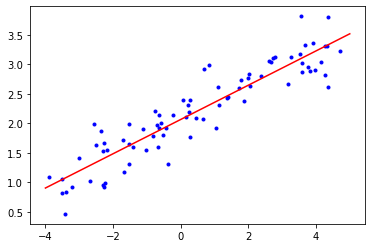

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N = 80
xs = np.random.random(N)*9-4
ys = 0.3*xs + 2.1 +  np.random.normal(size=N,scale=0.3)
f = np.poly1d(np.polyfit(xs,ys,deg=1))([-4,5])

plt.plot(xs,ys,'b.'); plt.plot([-4,5],f,'-r'); plt.show()

## Pasos a seguir:

    1. Proponemos un modelo:
<font size=6>
$$\hat{Y} = mX + b$$ 
</font>

    2. Optimizamos los parámetros: Minimiza la diferencia entre el dato real y el valor que da nuestra función.

<img src="./Images/Linear_least_squares_example2.png" width='150'>

---

## Pero qué pasa si el modelo no es suficiente?

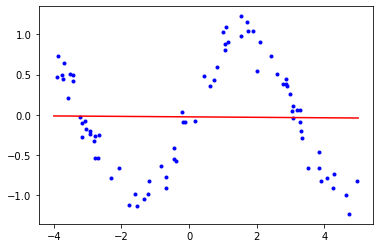

In [2]:
N = 80
xs = np.random.random(N)*9-4
ys = np.sin(xs) + np.random.normal(size=N,scale=0.15)
f = np.poly1d(np.polyfit(xs,ys,deg=1))([-4,5])

plt.plot(xs,ys,'b.'); plt.plot([-4,5],f,'-r'); plt.show()

### Ejemplo: Visión computacional. 
\
\
<font size=6>
    Tarea: Hacer que un computador pueda clasificar imágenes.
</font>

<img src="Images/f_dogvsmuff.png" width='400'>

<br>
<br>
<br>

<font color='red' size=6>
    Tenemos que usar modelos más complejos.
</font>

---

<br>
<br>
<br>
<br>
<br>

---
# 1. Te consigues los datos:
<img src="Images/chihuahua_vs_muffin_400px_web.jpg" width='400'>

# 2. Y un modelo suficientemente poderoso

- Redes neuronales:
<img src="Images/neuralnet.png" width='500'>


Cada neurona:

<font size="6" color='blue'>
$$
N_i = \sigma (w_1^ix_1 + w_2^ix_2 + w_3^ix_3 + ...)
$$
</font>

---

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

---

<font color='#28e425' size=6>
    Pregunta: Colisión de moléculas
</font>

## Usamos ecuación de Newton para cada átomo:
<br>
<font color='#a826cf' size=6>
    $$
    \begin{align*}
    F&=ma\\
    F&=-\nabla E
    \end{align*}
    $$
</font>

<br>
<br>

<font color='black' size=6>
    $$
    \begin{align*}
    \Rightarrow  a = -\frac{1}{m} \nabla E
    \end{align*}
    $$
</font>
<br>
<br>
<font color='black' size=6>
    Con estas ecuaciones, podemos usar algoritmos para calcular una trayectoria.
</font>

<img src="Images/PES_img_path.png" width='500'>

---
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

---

<img src="Images/arjona.jpeg" width='400'>
<font size=1>
https://www.generadormemes.com/imagenes/ricardo-arjona-el-problema/
</font>

<br>
<br>

<font color='black' size=6>
    Tenemos que calcular el gradiente de la energía en cada punto!
</font>

---

<br>
<br>
<br>
<br>
<br>
<br>

---

<font color='#4fa072' size=6>
      La energía es una función de las coordenadas!
</font>

# Podemos usar redes neuronales para aproximar una PES.
De esta manera es más barato computacionalmente.

---

## Tareas:

- [ ] Construir conjunto de datos.
- [ ] Construir red neuronal (Elegir arquitectura)
- [ ] Entrenar NN.
    - [ ] Evaluar qué tan buena es
- [ ] Ahora sí, corramos trayectorias!

# 1. Construir conjunto de datos.

### El sistema que vamos a usar es H$_2$CO$^+$.

<font size=3.5>
    La idea es empezar desde estructuras relevantes (mínimos, TSs), como los reportados en  <a href="https://aip.scitation.org/doi/10.1063/1.2181571">Moyano 2006</a> 
</font>


<img src="Images/h2co_min.png" width='200'>

<img src="Images/Structs.png" width='900'>

# Vamos a generar algunas estructuras nuevas, alrededor de estas estructuras relevantes.

### Por ejemplo, si estas son los mínimos:

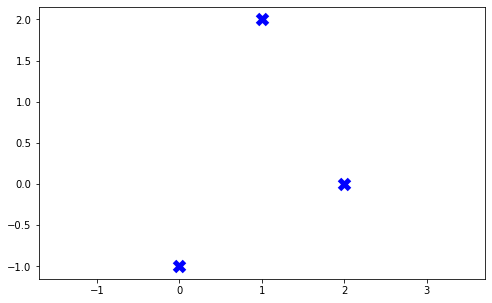

In [3]:
fig,ax = plt.subplots(figsize=(8,5))

seeds_x = [0,1,2]
seeds_y = [-1,2,0]
ax.scatter(seeds_x,seeds_y,s=100,marker='x',linewidths=5,color='b')
ax.axis('equal');

## Generamos algunas estructuras aleatorias alrededor de cada punto:

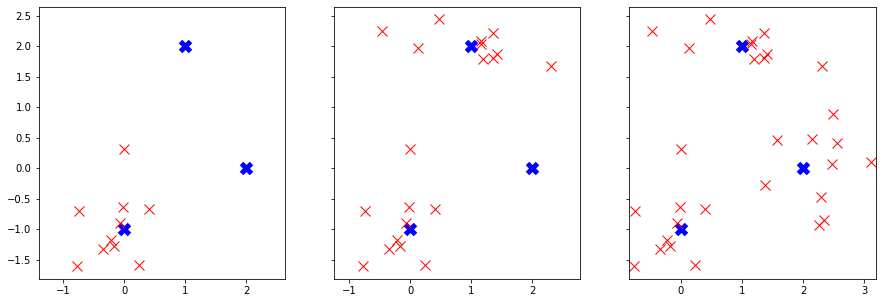

In [4]:
fig,ax = plt.subplots(1,3,figsize=(15,5),sharey=True)

new_pts_x = [] ; new_pts_y = []

scal = 0.5
NperPt = 10
for i in range(3):
    new_pts_x = new_pts_x + list(np.random.normal(size=NperPt,loc=seeds_x[i],scale=scal))
    new_pts_y = new_pts_y + list(np.random.normal(size=NperPt,loc=seeds_y[i],scale=scal))
    ax[i].scatter(seeds_x,seeds_y,s=100,marker='x',linewidths=5,color='b')
    ax[i].scatter(new_pts_x,new_pts_y,s=100,marker='x',linewidths=1,color='r')
    ax[i].axis('equal')
plt.show()

## Ahora sí, a hacer todo

In [5]:
from aux import *
tf.enable_eager_execution()

### Las columnas son: coordenadas xyz de O, C, H1, H2 (Ox, Oy, Oz, Cx, ...)

In [6]:
df = loadCoords(file='../Data/Structs.xyz')
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
m10,0.018902,0.0,0.007275,-0.227835,0.0,1.142721,0.230513,0.0,-0.966525,9.074669,0.0,-17.712857
m11,12.285352,0.0,-4.190886,12.574280,0.0,-3.136145,-0.039439,0.0,-0.055729,0.152842,0.0,0.657169
m12,0.000000,0.0,0.000000,0.000000,0.0,1.093536,0.201882,0.0,-3.174882,0.927414,0.0,-3.034873
m1,0.000000,0.0,1.217334,0.000000,0.0,0.000000,0.819430,0.0,-0.733547,0.869755,0.0,1.691461
m2,-0.022028,0.0,1.335390,0.063013,0.0,0.115731,1.009366,0.0,-0.441728,-0.937213,0.0,1.710607


Now compute energy for these initial configurations

## Ya tenemos las 'Semillas'. Vamos a generar datos alrededor de estas (que sean ~1500 configuraciones):

In [7]:
#Loop through the initial configurations and create new examples
Nsamples = 1500

NperStruct = int(Nsamples/df.shape[0])
for struct in df.index:
    OrigCoords = df.loc[struct]
    for j in range(NperStruct):
        newExamp = OrigCoords + np.random.normal(loc=0,scale=0.1,size=12)
        df = df.append(newExamp)
        
df.reset_index(drop=True,inplace=True)
df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11
1520,-0.123725,-0.061801,-0.011710,-0.112710,-0.070765,1.109733,3.054768,-0.079845,2.102449,-0.159884,0.058224,-0.998602
1521,0.038931,-0.021160,-0.148109,-0.053505,-0.012961,1.181142,2.968534,-0.123110,2.102328,0.054858,0.039862,-1.056868
1522,0.015733,0.041281,-0.154436,-0.179457,0.030558,1.145014,3.008393,-0.154101,1.903491,0.074432,-0.015080,-1.090272
1523,-0.054954,-0.140678,-0.251776,-0.031747,-0.029871,1.288591,2.890288,0.141423,2.136830,0.122562,0.074606,-0.905727
1524,0.030255,-0.049558,0.097189,-0.116205,0.004355,1.111518,2.909554,-0.063856,1.976406,-0.159433,0.029585,-0.891523


## También tenemos que calcular la energía en cada una de estas nuevas configuraciones.
<br>
<font size=6 color='red'>
    sino, pues el algoritmo no tiene de donde aprender
</font>

In [9]:
%%time
#Finally, calculate the energies for these configurations
df['energy'] = df.apply(HFenergy,axis=1)

#Select all configurations that didn't return an error
df = df[df.energy != 0.0]
df.to_csv('../Data/newEDF.csv',index=False)  #Save

df.head()

CPU times: user 22min 52s, sys: 48.7 s, total: 23min 41s
Wall time: 25min 20s


,0,1,2,3,4,5,6,7,8,9,10,11,energy
0,0.018902,0.0,0.007275,-0.227835,0.0,1.142721,0.230513,0.0,-0.966525,9.074669,0.0,-17.712857,-113.424919
1,12.285352,0.0,-4.190886,12.574280,0.0,-3.136145,-0.039439,0.0,-0.055729,0.152842,0.0,0.657169,-113.401075
2,0.000000,0.0,0.000000,0.000000,0.0,1.093536,0.201882,0.0,-3.174882,0.927414,0.0,-3.034873,-113.401458
3,0.000000,0.0,1.217334,0.000000,0.0,0.000000,0.819430,0.0,-0.733547,0.869755,0.0,1.691461,-113.514051
4,-0.022028,0.0,1.335390,0.063013,0.0,0.115731,1.009366,0.0,-0.441728,-0.937213,0.0,1.710607,-113.519105


In [8]:
dataset = pd.read_csv('../Data/newEDF.csv')
dataset.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,energy
1470,-0.059597,0.045899,0.023483,0.201739,0.098260,1.040121,3.149622,-0.023382,2.197340,-0.022247,0.013988,-1.125355,-113.387267
1471,0.082468,-0.058548,-0.152272,-0.054224,0.015134,1.110995,2.968702,-0.045684,2.097381,0.204792,-0.019811,-1.065161,-113.394427
1472,-0.142561,-0.139416,0.004717,-0.094565,-0.017217,1.195770,3.109141,-0.067436,2.139305,0.008012,0.086349,-0.981902,-113.419421
1473,-0.071759,0.038233,-0.124448,0.077995,0.060714,1.152396,2.948923,0.028941,2.061696,0.073194,-0.114710,-0.950063,-113.374957
1474,-0.031120,0.085282,-0.034407,0.067199,0.058419,1.132609,3.006498,0.069126,2.009551,0.060714,-0.214376,-0.823244,-113.403712


<font color='#dd2323' size=7>
    Entre más datos tengamos, mejor.
</font>

### Podemos hacer un truco: aprovechar que hay 2 átomos iguales, así que si intercambiamos 1 átomo de H por el otro, la energía es la misma!
<br>
<font color='#e4238a' size=6>
Esto nos aumenta la cantidad de datos x2, ¡sin tener que calcular nada más!
</font>

In [9]:
#Permutational symmetry considerations: energy is the same upon H exchange
#O,C,H1,H2 --> O,C,H2,H1
newdf = dataset.copy()
h1 = newdf.loc[:,['6','7','8']].copy()
h2 = newdf.loc[:,['9','10','11']].copy()

newdf.loc[:,['6','7','8']] = h2.values
newdf.loc[:,['9','10','11']] = h1.values

newdf = newdf.reset_index(drop=True)

dataset = pd.concat([dataset,newdf])
dataset.shape

(2950, 13)

# Finalmente, vamos a reducir los grados de libertad:

## Para la energía, solo nos interesan posiciones relativas (como en la matriz Z).
<br>
<font color='#9f23dd' size=6>
 En este caso, vamos a calcular todas las distancias atómicas (6 en este caso).
</font>

In [10]:
featDF = dataset.drop(columns=['energy']).apply(getInput,axis=1)
featDF['energy'] = dataset.energy

columns = []
#Same loops
for i in range(len(atoms)):
    for j in range(i+1,len(atoms)):  #Only atoms after ith (not counting it)
        columns.append(atoms[i]+atoms[j])
featDF.columns = columns + ['energy']

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
featDF.to_csv("../Data/train.csv",index=False)

## I'm not using train/test split since we're testing using classical dynamics. The error can be measured with a validation set but this inside the training procedure.

In [12]:
train = pd.read_csv('../Data/train.csv')

minE = train.energy.min()
train.energy = (train.energy - minE)
train.tail()

,OC,OH1,OH2,CH1,CH2,H1H2,energy
2945,0.951479,0.869650,0.257945,0.458998,0.315535,0.217687,0.146695
2946,0.785685,1.084761,0.273266,0.456247,0.314429,0.238085,0.139534
2947,0.834539,0.977270,0.257043,0.458181,0.299389,0.227140,0.114540
2948,0.777731,1.173596,0.268184,0.473985,0.332043,0.240000,0.159004
2949,0.853636,1.178109,0.273127,0.506381,0.326015,0.244100,0.130250


# Por fin terminamos de crear el conjunto de datos.


# 2. Construir y entrenar la red neuronal

In [13]:
def getModel():
    model = keras.Sequential(
        [keras.Input(shape=(6,)),
         Dense(254,activation='relu'),
         Dense(128,activation='relu'),
         Dense(128,activation='relu'),
         Dense(64,activation='relu'),
         Dense(1,activation='linear')]
    )
    model.compile(optimizer='adam',loss='mae')
    return model

In [14]:
model = getModel()

xs = train.drop(columns=['energy'])
ys = train.energy

RedLR = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,
                                          patience=20,verbose=0)
CheckP = keras.callbacks.ModelCheckpoint('../Data/PES.hdf5',monitor="val_loss",save_best_only=True)


model.fit(xs,ys,batch_size=32,epochs=500,validation_split=0.15,
          callbacks=[RedLR,CheckP]);

Train on 2507 samples, validate on 443 samples
Epoch 1/500
2507/2507 [==============================] - 1s 201us/sample - loss: 0.0545 - val_loss: 0.0472
Epoch 2/500
2507/2507 [==============================] - 0s 77us/sample - loss: 0.0496 - val_loss: 0.0474
Epoch 3/500
2507/2507 [==============================] - 0s 79us/sample - loss: 0.0449 - val_loss: 0.0460
Epoch 4/500
2507/2507 [==============================] - 0s 69us/sample - loss: 0.0402 - val_loss: 0.0480
Epoch 5/500
2507/2507 [==============================] - 0s 102us/sample - loss: 0.0396 - val_loss: 0.0402
Epoch 6/500
2507/2507 [==============================] - 0s 88us/sample - loss: 0.0363 - val_loss: 0.0424
Epoch 7/500
2507/2507 [==============================] - 0s 82us/sample - loss: 0.0329 - val_loss: 0.0397
Epoch 8/500
2507/2507 [==============================] - 0s 79us/sample - loss: 0.0323 - val_loss: 0.0386
Epoch 9/500
2507/2507 [==============================] - 0s 98us/sample - loss: 0.0286 - val_loss: 0.03

2507/2507 [==============================] - 0s 66us/sample - loss: 0.0081 - val_loss: 0.0202
Epoch 78/500
2507/2507 [==============================] - 0s 65us/sample - loss: 0.0070 - val_loss: 0.0174
Epoch 79/500
2507/2507 [==============================] - 0s 68us/sample - loss: 0.0071 - val_loss: 0.0185
Epoch 80/500
2507/2507 [==============================] - 0s 71us/sample - loss: 0.0077 - val_loss: 0.0191
Epoch 81/500
2507/2507 [==============================] - 0s 67us/sample - loss: 0.0078 - val_loss: 0.0207
Epoch 82/500
2507/2507 [==============================] - 0s 74us/sample - loss: 0.0082 - val_loss: 0.0213
Epoch 83/500
2507/2507 [==============================] - 0s 66us/sample - loss: 0.0075 - val_loss: 0.0199
Epoch 84/500
2507/2507 [==============================] - 0s 67us/sample - loss: 0.0084 - val_loss: 0.0196
Epoch 85/500
2507/2507 [==============================] - 0s 70us/sample - loss: 0.0083 - val_loss: 0.0175
Epoch 86/500
2507/2507 [==========================

2507/2507 [==============================] - 0s 61us/sample - loss: 0.0041 - val_loss: 0.0116
Epoch 154/500
2507/2507 [==============================] - 0s 55us/sample - loss: 0.0042 - val_loss: 0.0109
Epoch 155/500
2507/2507 [==============================] - 0s 60us/sample - loss: 0.0042 - val_loss: 0.0104
Epoch 156/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0043 - val_loss: 0.0118
Epoch 157/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0041 - val_loss: 0.0121
Epoch 158/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0041 - val_loss: 0.0112
Epoch 159/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0038 - val_loss: 0.0119
Epoch 160/500
2507/2507 [==============================] - 0s 57us/sample - loss: 0.0045 - val_loss: 0.0118
Epoch 161/500
2507/2507 [==============================] - 0s 58us/sample - loss: 0.0038 - val_loss: 0.0108
Epoch 162/500
2507/2507 [=================

Epoch 229/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0019 - val_loss: 0.0103
Epoch 230/500
2507/2507 [==============================] - 0s 64us/sample - loss: 0.0019 - val_loss: 0.0102
Epoch 231/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0020 - val_loss: 0.0105
Epoch 232/500
2507/2507 [==============================] - 0s 58us/sample - loss: 0.0020 - val_loss: 0.0108
Epoch 233/500
2507/2507 [==============================] - 0s 60us/sample - loss: 0.0020 - val_loss: 0.0108
Epoch 234/500
2507/2507 [==============================] - 0s 61us/sample - loss: 0.0020 - val_loss: 0.0102
Epoch 235/500
2507/2507 [==============================] - 0s 56us/sample - loss: 0.0018 - val_loss: 0.0104
Epoch 236/500
2507/2507 [==============================] - 0s 59us/sample - loss: 0.0019 - val_loss: 0.0106
Epoch 237/500
2507/2507 [==============================] - 0s 55us/sample - loss: 0.0019 - val_loss: 0.0105
Epoch 238/500
2507/2507 [===

Epoch 305/500
2507/2507 [==============================] - 0s 60us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 306/500
2507/2507 [==============================] - 0s 58us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 307/500
2507/2507 [==============================] - 0s 72us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 308/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 309/500
2507/2507 [==============================] - 0s 57us/sample - loss: 0.0012 - val_loss: 0.0104
Epoch 310/500
2507/2507 [==============================] - 0s 58us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 311/500
2507/2507 [==============================] - 0s 54us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 312/500
2507/2507 [==============================] - 0s 64us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 313/500
2507/2507 [==============================] - 0s 66us/sample - loss: 0.0012 - val_loss: 0.0103
Epoch 314/500
2507/2507 [===

Epoch 381/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 382/500
2507/2507 [==============================] - 0s 56us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 383/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 384/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 385/500
2507/2507 [==============================] - 0s 51us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 386/500
2507/2507 [==============================] - 0s 51us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 387/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 388/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 389/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 390/500
2507/2507 [===

Epoch 457/500
2507/2507 [==============================] - 0s 50us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 458/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 459/500
2507/2507 [==============================] - 0s 55us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 460/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 461/500
2507/2507 [==============================] - 0s 52us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 462/500
2507/2507 [==============================] - 0s 50us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 463/500
2507/2507 [==============================] - 0s 51us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 464/500
2507/2507 [==============================] - 0s 53us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 465/500
2507/2507 [==============================] - 0s 51us/sample - loss: 0.0011 - val_loss: 0.0103
Epoch 466/500
2507/2507 [===

In [16]:
model = getModel()
model.load_weights('../Data/PES.hdf5')

def E(coords):
    return model.predict(coords) + minE

## Tenemos un error promedio de 0.0084 Hartree (5.271 kcal/mol).

### Mientras que el trabajo de referencia obtuvo 1.195 kcal/mol. 
<br>
<br>
<font color='#109148' size=6>
    Peeero: En ese trabajo calcularon Energías, Gradientes y Hessianas para interpolar con expansiones de Taylor.
</font>

---

<br>
<br>
<br>
<br>

---

## Vamos a hacer una prueba rápida: Veamos la calidad de la PES en una IRC de interés.

<img src='Images/IRC.png' width=400>

In [17]:
%%time
irc = loadCoords_IRC('../Data/ts3.irc')

#Some operations before plotting
tmp1 = irc.iloc[22:].sort_values(by='energy')
tmp2 = irc.iloc[:22]
IRC = pd.concat([tmp1,tmp2])

#Calculate energies using selected method and basis set (UHF/cc-pVDZ)
IRC['HF'] = IRC.drop(columns='energy').apply(HFenergy,axis=1)

ircFeats = IRC.drop(columns=['HF','energy']).apply(getInput,axis=1)
ircFeats['HF'] = IRC.HF

columns = []
#Same loops
for i in range(len(atoms)):
    for j in range(i+1,len(atoms)):  #Only atoms after ith (not counting it)
        columns.append(atoms[i]+atoms[j])
ircFeats.columns = columns + ['HF']

CPU times: user 35.1 s, sys: 532 ms, total: 35.7 s
Wall time: 37.7 s


## Con esto, acabamos de calcular las energías de cada punto en la IRC, con HF/cc-pVDZ. Veamos qué tal es la NN.

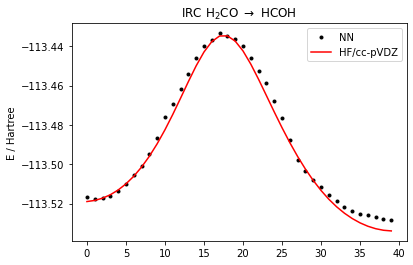

In [18]:
predictedIRC = E(ircFeats.drop(columns='HF'))

fig,ax = plt.subplots()
ax.plot(predictedIRC,'k.',label='NN')
ax.plot(ircFeats.HF.values,label='HF/cc-pVDZ',color='r')
ax.legend()

ax.set_title(r'IRC H$_2$CO $\rightarrow$ HCOH')
ax.set_ylabel('E / Hartree')
plt.show()

# 3.  Ahora sí, corramos trayectorias!
<br>
<br>
<br>
<font color='#1730c7' size=6>
    Ya los algoritmos integradores están implementados, sólo falta ponerle condiciones iniciales (posición y velocidad).
</font>

<br>

### Vamos a simular una colisión entre H y HCO$^+$. Chocamos los dos fragmentos, y vemos qué sale!

In [69]:
def Init_conds(v0=10000):
    """Define coordenadas y velocidades iniciales.
    HCO+ muy cerca a mínimo, H entre 7 y 9 Angstrom.
    Argumentos: v0 = velocidad relativa entre fragmentos, en m/s"""
    # Definamos posición del fragmento HCO+
    xOCH = np.array([[0.000000, 0.000000, -1.598843],
                     [0.000000, 0.000000, -0.504771],
                     [0.000000, 0.000000, 0.578434]])
    # Y posición del H (que sea aleatoria, a entre 6 y 8 Angstrom)
    r = np.random.random()*2+6
    phi = np.random.random()*np.pi
    theta = np.random.random()*2*np.pi
    
    xH = np.array([[np.sin(phi)*np.cos(theta),
                   np.sin(phi)*np.sin(theta),
                   np.cos(phi)]])*r
    
    X0 = np.concatenate([xOCH,xH]).reshape(1,-1)
    
    # Ahora definimos velocidades (las trayectorias reactivas ocurren por colisiones)
    unit = xH - xOCH.mean(axis=0)  # Promedio de distancias
    unit = unit/np.linalg.norm(unit)   #Unit vector pointing in the direction HCO to H
    V0 = np.zeros(12).reshape(1,-1) 
    V0[:,9:] = -(v0*unit*1e10).reshape(1,-1)  # Convierte a Ang/s, y le da dirección 
    return X0,V0

# 9000 m/s is about 41 kJ/mol.

# Moyano et al report relative kinetic energies in the range 13.1 to 26.3 kJ/mol, which correspond to 5100 - 7223 m/s

In [77]:
%%time

v0 = 20000
#Now same traj with our NN PES

for i in range(10):
    NNtraj = Trajectory(*Init_conds(v0),Nsteps=2000,timeDelta=1e-16,
                        saveMolden=f'../Data/NNtraj{i}.txt',
                        gradient=Grad,model=model)
    NNtraj.run()

Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
Trajectory completed!
CPU times: user 1min 44s, sys: 29.7 ms, total: 1min 44s
Wall time: 1min 44s


The trajectories have been stored to the file `HFtraj.txt` and `NNtraj`. It can be viewed with some visualization program such as [MOLDEN](http://cheminf.cmbi.ru.nl/molden/molden.html).

<img src="Images/sample-trajNN.gif" width="450" align="center">

### El código que sigue, corre la misma trayectoria, pero con los gradientes reales (HF/cc-pVDZ)

In [74]:
def HFgrad(model,row):
    """model is a dummy variable for compatibility
    Real gradient at HF/cc-pVDZ.
    This is expensive, use only for comparison
    Documentation: http://psicode.org/psi4manual/1.3.2/opt.html
    """
    psi4.set_memory('500 MB')

    #charge = +1, spin multipicity = 2
    h2o = psi4.geometry("""
    1 2
    O {} {} {}
    C {} {} {} 
    H {} {} {}
    H {} {} {}
    """.format(*row))
    
    psi4.set_options({'reference': 'uhf'})
    
    #Gradient calculated using UHF/cc-pVDZ
    try: 
        #Gradient is returned in Hartree/bohr -> convert to Hartree/ang
        return np.array(psi4.gradient('scf/cc-pvdz') ).flatten()  * 1.8897161 
    except:  #In case there's a convergence error or alike
        return 0.0

In [75]:
%%time

X0,V0 = Init_conds(7000)

#Let's run a traj with full HF gradients for comparison
HFtraj = Trajectory(X0,V0,Nsteps=2000,timeDelta=1e-16,saveMolden='../Data/HFtraj_1.txt',gradient=HFgrad)
HFtraj.run()

Trajectory completed!
CPU times: user 31min 47s, sys: 31.3 s, total: 32min 18s
Wall time: 34min 58s


In [76]:
NNtraj = Trajectory(X0,V0,Nsteps=2000,timeDelta=1e-16,
                        saveMolden=f'../Data/NNtraj_1.txt',
                        gradient=Grad,model=model)
NNtraj.run()

Trajectory completed!
